# 📌 Intro.
- 지난 노드에서는 nltk를 기반으로 seq2seq를 사용해서 영문 텍스트(뉴스기사)의 샘플 데이터를 가지고 `Abstractive summarization 방식의 텍스트 요약기` 를 만드는 실습을 했습니다.
- 해당 과정에서 텍스트 데이터를 전처리하는 방법, seq2seq 구현을 위한 Encoder, Decoder 구현하는 방법, 인퍼런스 모델 만들어서 사용하는 방법 등을 배웠습니다.
- 이번 프로젝트에서는 배웠던 내용을 바탕으로 새로운 데이터셋을 가지고 `Abstractive summarization` 과 `Extractive Summarization` 을 모두 구현하는 프로젝트를 진행합니다.

---

- 평가 루브릭은 아래와 같습니다.

| 평가 문항                                  | 평가 기준                                                                                                       |
|----------------------------------------|-----------------------------------------------------------------------------------------------------------------|
| 1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. | - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.        |
| 2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.         | - 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다. |
| 3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다. | - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.     |

---

In [2]:
import tensorflow as tf
import nltk
import summa # ver. 1.2.0
import pandas as pd

# GPU활성화 코드
print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
        # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)
        


print(nltk.__version__)
print(tf.__version__)
print(pd.__version__)

Num GPUs Available:  1
3.8.1
2.6.0
1.3.5


In [3]:
import nltk
nltk.download('stopwords')

import numpy as np
import re
import matplotlib.pyplot as plt
import koreanize_matplotlib
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1. 데이터 수집하기
- 아래 링크에서 제공하는 뉴스 기사 데이터(`news_summary_more.csv`) 를 사용해 프로젝트를 진행합니다.

- [데이터 링크](https://github.com/sunnysai12345/News_Summary)
- 해당 링크에서 다운 받은 파일은 아래와 와 같은 경로에 저장합니다.

```python
[AIFFEL] study_code/
└── data/
    └── text_summary/
        └── news_summary_more.csv
```

In [3]:
import os
import urllib.request

# 데이터 다운로드 폴더 경로 설정
download_folder = "data/text_summary"

# 폴더가 존재하지 않으면 생성
if not os.path.exists(download_folder):
    os.makedirs(download_folder)

# 데이터 다운로드 및 불러오기
url = "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv"
filename = os.path.join(download_folder, "news_summary_more.csv")

# 데이터 다운로드
urllib.request.urlretrieve(url, filename)

# 데이터 불러오기
data = pd.read_csv(filename, encoding='iso-8859-1')

In [4]:
# 데이터 샘플 확인
data.sample(10)

,headlines,text
10465,24-year-old Bajrang becomes world no. 1 wrestl...,Asian Games and Commonwealth Games gold medall...
81536,Ã¢ÂÂ¹1.5 crore for Mumbai's 6th Shivaji statue,The Railways will spend an estimated Ã¢ÂÂ¹1.5...
32196,"PM Modi on airplane or speaker mode, never wor...",Referring to the different modes in a mobile p...
51815,China's infrastructure development in Doklam t...,Stating that there are Chinese troops in a par...
39597,Not paying for N Korean officials' stay in Sin...,The US State Department on Tuesday said that t...
62377,Kerala Minister vacates home for national high...,Kerala's Public Works Department Minister G Su...
43443,Sierra Leone 1st country to use blockchain tec...,The African nation of Sierra Leone has become ...
10933,"Main accused in Varanasi mall shooting, which ...",The main accused in the shooting at a shopping...
67532,Pope wears refugee bracelet in appeal for help...,Pope Francis was seen wearing a refugee ID bra...
31524,Collegium to again name judge for SC post Cent...,The Supreme Court Collegium has decided to aga...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


- 데이터가 기사의 본문(`text`) 컬럼과 `headline` 두 부분으로 구성되어 있습니다.
- 추상적 요약(Abstractive summarization)을 하고자 한다면 `headlines` 컬럼의 텍스트들을 `이미 요약된 데이터` 로 지침삼아 모델을 학습하도록 할 수 있습니다.

# Step 2. 데이터 전처리 (추상적 요약)

- 모델에 학습하기 위해 필요한 정보들만 추려서 모델이 입력할 수 있는 형태로 가공해야 합니다.
- 분석단계, 정제단계, 정규화, 불용어제거, 데이터셋 분리, 인코딩을 진행해야 합니다.

## 텍스트 데이터 분석

- 모델링에 앞서 다양한 방법으로 텍스트들을 분석하여 전처리 방향을 정하도록 하겠습니다.

- 일단 텍스트 길이에 대한 분석을 진행해보겠습니다.

### 중복 데이터 확인

In [6]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


- 전체 데이터가 98,401개였음을 감안하면 중복데이터는 거의 없는 것으로 판단 됩니다.
- 데이터셋 자체가 이전에 실습때보다는 다양성이 높은 데이터인 것이 명확해 보입니다.
- 일단 중복 제거를 해준 뒤 데이터의 길이를 파악해보겠습니다.

In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 중복된 데이터를 제거하여 중복된 데이터가 적절하게 처리된 것 같습니다.
- 이제 텍스트의 길이를 통해 데이터 특성을 파악해보겠습니다.

### 헤드라인과 본문의 길이 파악

In [10]:
# 헤드라인 및 본문의 단어 수 계산
data['headline_word_count'] = data['headlines'].apply(lambda x: len(x.split()))
data['text_word_count'] = data['text'].apply(lambda x: len(x.split()))

# 헤드라인과 본문의 길이 분석 결과 출력
print("헤드라인의 평균 길이:", data['headline_word_count'].mean())
print("헤드라인의 최소 길이:", data['headline_word_count'].min())
print("헤드라인의 최대 길이:", data['headline_word_count'].max())

print("본문의 평균 길이:", data['text_word_count'].mean())
print("본문의 최소 길이:", data['text_word_count'].min())
print("본문의 최대 길이:", data['text_word_count'].max())

헤드라인의 평균 길이: 9.553660024400163
헤드라인의 최소 길이: 1
헤드라인의 최대 길이: 18
본문의 평균 길이: 58.23813542090281
본문의 최소 길이: 1
본문의 최대 길이: 91


- 일단 가장 눈에 띄는 특징은 두 컬럼 모두 최소길이가 1인 컬럼이 있다는 것입니다.
- 단어수를 기준으로 했으니 1개의 단어만 있다는 것인데, 이 데이터가 같은 row일지, 제각각일지, 단어가 1개인 데이터는 무엇인지 확인해보겠습니다.

In [11]:
# 길이가 1인 헤드라인과 본문 데이터 추출
min_length_headlines = data[data['headlines'].apply(lambda x: len(x.split())) == 1]
min_length_text = data[data['text'].apply(lambda x: len(x.split())) == 1]

# 추출된 데이터를 DataFrame으로 표시
df_min_length = pd.DataFrame({'Headlines': min_length_headlines['headlines'], 'Text': min_length_text['text']})

# 최소 길이가 1인 데이터 확인
df_min_length

,Headlines,Text
52,headlines,text


- 아마 샘플데이터여서 포함된 데이터같습니다. 
- 바로 drop해서 결측치를 처리하고 내용을 다시 확인하겠습니다.

In [12]:
# 해당 데이터 삭제
data.drop(min_length_headlines.index, inplace=True)
# data.drop(min_length_text.index, inplace=True) # 같은 행이므로 위에서 이미 삭제됨

# 헤드라인 및 본문의 단어 수 계산
data['headline_word_count'] = data['headlines'].apply(lambda x: len(x.split()))
data['text_word_count'] = data['text'].apply(lambda x: len(x.split()))

# 헤드라인과 본문의 길이 분석 결과 출력
print("헤드라인의 평균 길이:", data['headline_word_count'].mean())
print("헤드라인의 최소 길이:", data['headline_word_count'].min())
print("헤드라인의 최대 길이:", data['headline_word_count'].max())

print("본문의 평균 길이:", data['text_word_count'].mean())
print("본문의 최소 길이:", data['text_word_count'].min())
print("본문의 최대 길이:", data['text_word_count'].max())

헤드라인의 평균 길이: 9.5537469880743
헤드라인의 최소 길이: 3
헤드라인의 최대 길이: 18
본문의 평균 길이: 58.23871735174209
본문의 최소 길이: 38
본문의 최대 길이: 91


- 이제 각 데이터의 분포를 시각화 해서 다시 살펴보겠습니다.

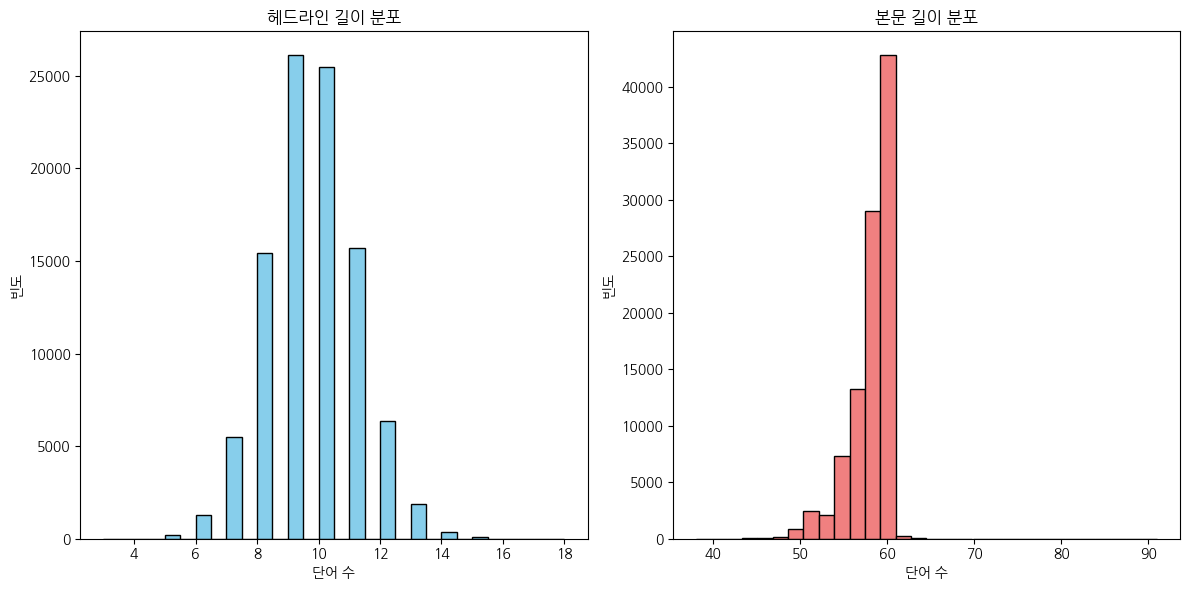

In [13]:
# 길이에 따른 분포 시각화
plt.figure(figsize=(12, 6))

# 헤드라인 길이 분포
plt.subplot(1, 2, 1)
plt.hist(data['headline_word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('헤드라인 길이 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')

# 본문 길이 분포
plt.subplot(1, 2, 2)
plt.hist(data['text_word_count'], bins=30, color='lightcoral', edgecolor='black')
plt.title('본문 길이 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

- 두 결과를 종합해보자면 아래와 같습니다.
- 1) 헤드라인
    - 헤드라인 단어수는 대부분 8~12 단어사이에 분포합니다.
    - 평균길이는 9.55로, 본문의 평균길이를 생각하면 상당히 간결하게 요약을 잘 해둔 것 같습니다.
    - 가장 짧은 헤드라인은 3개의 단어로 이뤄졌지만, 가장 긴 헤드라인은 18단어로 이뤄져 있기도 합니다.
- 2) 본문
    - 본문 단어수는 주로 50~70 개의 단어에 집중되어 있습니다.
    - 평균길이는 약 58개의 단어로 구성되어 있어 상당히 긴 문장으로 구성되어 있음을 알 수 있습니다.
    - 가장 짧은 본문도 38개의 단어로 되어있어 본문의 내용이 상당히 긴편임을 알 수 있습니다.
    
---

- 🤔 요약모델을 만들기 위해 고려해야 할 것
    - 길이 표준화
        - 헤드라인과 본문 모두 길이가 비교적 일관적입니다.
        - 너무 길거나 짧은 데이터만 제거해도 충분히 학습하기에 적절한 데이터가 될 수 있습니다.
        - 최소길이와 최대길이의 편차가 그리 크지 않아 모델 학습에 큰 영향을 미치지는 않을 것 같습니다.
        - 극단적으로 짧거나 긴 데이터를 제외하지 말고 단순히 모델이 처리할 수 있는 최대길이를 지정하는 것이 적절해 보입니다.
        - 이를 통해 모델이 일정 길이의 텍스트를 출력하도록 할 수 있을 것 같습니다.   
    - 기본적인 전처리
        - 노이즈를 줄이기 위해 특수문자, 숫자, 불필요한 공백등을 제거해야 합니다.

### 단어 빈도 분석

- 자주 사용되는 단어들을 파악합니다.
- 헤드라인과 본문에서도 각각 자주 사용되는 단어를 파악함으로 둘이 어떻게 다른 단어들을 사용하는지 파악해보겠습니다.
- 대부분의 단어들이 불용어 위주로 최빈단어가 될 것이므로, 텍스트 정규화(Text Normalization)을 한 뒤에 빈도 분석을 진행하겠습니다.

#### 텍스트 정규화 및 불용어 제거

In [14]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [15]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [16]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [17]:
# 전체 text 컬럼의 데이터에 대한 전처리
clean_text = [preprocess_sentence(text) for text in data['text']]

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [18]:
# 전체 headlines 컬럼의 데이터에 대한 전처리
clean_headlines = [preprocess_sentence(headlines, False) for headlines in data['headlines'].fillna('')]

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [21]:
# 데이터프레임에 'text' 열과 'headlines' 열에 정제된 텍스트를 할당
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [22]:
# Null값 유무 확인
data.isnull().sum()

headlines              0
text                   0
headline_word_count    0
text_word_count        0
dtype: int64

- 정규화 과정을 거쳤지만 데이터에서 처리되어 null이 발생된 데이터는 없었습니다.
- 헤드라인의 경우만 해도 최소단어수가 3개였을 정도로 데이터의 구성에서 길이가 짧지 않아 이런 과정에서도 살아남은 것 같습니다.

In [25]:
# 정규화한 데이터 세이브
processed_data = data.copy()

processed_data.to_csv('processed_data.csv', index=False)

In [45]:
data = pd.read_csv('processed_data.csv')

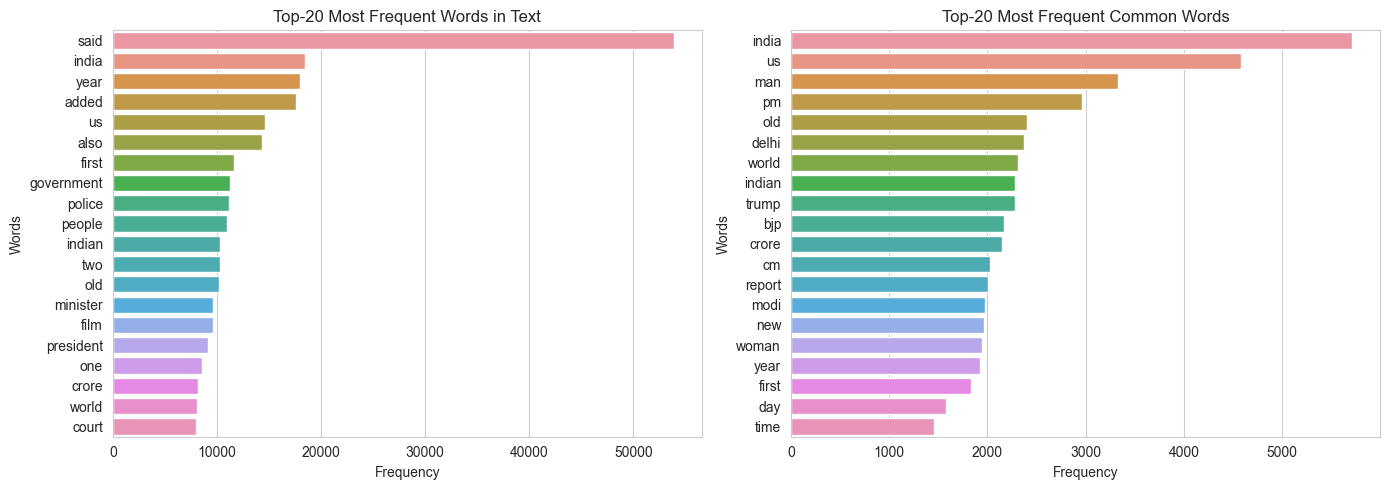

In [63]:
# Seaborn 스타일 설정
sns.set_style("whitegrid")

top_n = 20

# 1행에 2개의 그래프를 시각화하기 위한 서브플롯 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 첫 번째 컬럼의 최빈단어 시각화 (가로 막대 그래프)
sns.barplot(y=list(words_text), x=list(counts_text), ax=axes[0], orient='h')
axes[0].set_title('Top-{} Most Frequent Words in Text'.format(top_n))
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')

# 두 컬럼에서 공통으로 등장하는 최빈단어 시각화 (가로 막대 그래프)
sns.barplot(y=list(words_keywords), x=list(counts_keywords), ax=axes[1], orient='h')
axes[1].set_title('Top-{} Most Frequent Common Words'.format(top_n))
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Words')

plt.tight_layout()
plt.show()

- 본문쪽에 텍스트 정규화를 하고 나니 다양한 텍스트들의 빈도가 높게 나타납니다.
- 다양한 단어들이 골고루 사용되고 있음을 확인했으므로, 이제는 학습용 데이터로 가공을 해보겠습니다.

## Train/Test Split

- 모델에 데이터를 입력하기 위해 학습에 사용할 데이터 크기를 정의하고, 문장의 시작과 끝을 표시해줘야 합니다.
- 문장의 시작과 끝을 표시해줘야 하는 이유는 앞서 정리한대로 seq2seq모델의 특징상 SOS, EOS 토큰을 함께 입력해 모델에게 입/출력의 경계를 알려주고 시퀀스 생성과정을 제어할 수 있도록 합니다.

### 샘플 최대 길이 구하기

- 위에서 했던 분석의 반복이 일부 있긴하지만, text와 headlines 컬럼별로 최소, 최대, 평균 길이를 구하고 시각화 합니다.

텍스트의 최소 길이 : 18
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10003151719721
헤드라인의 최소 길이 : 3
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299616710214622


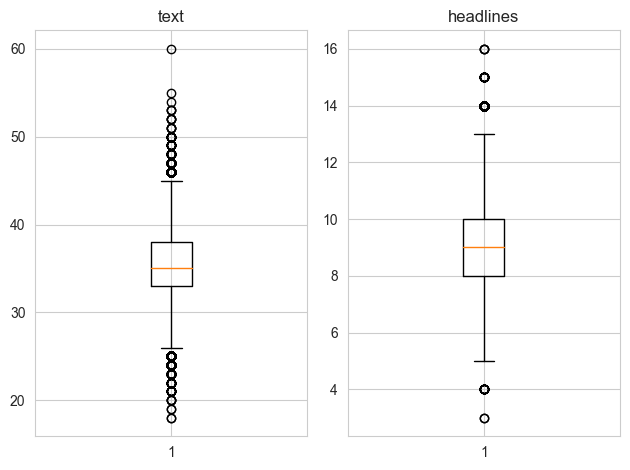

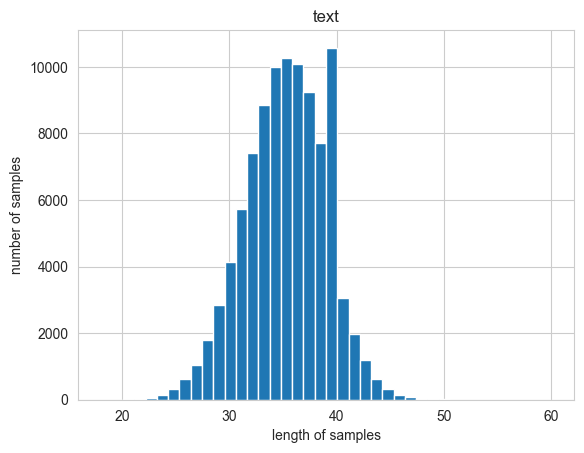

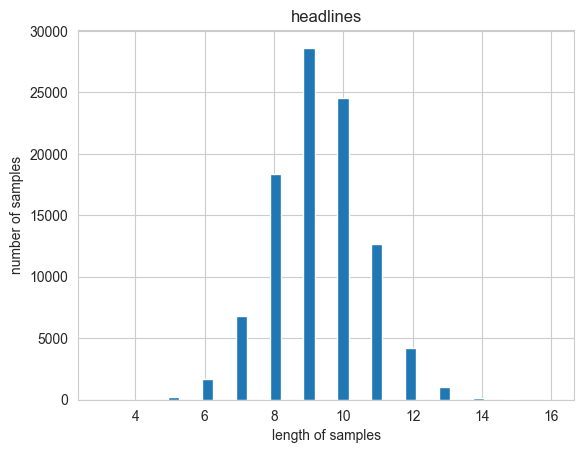

In [64]:
# 데이터셋에서 각 텍스트 샘플의 단어 수를 리스트에 저장
text_len = [len(s.split()) for s in data['text']]
# 데이터셋에서 각 헤드라인 샘플의 단어 수를 리스트에 저장
headlines_len = [len(s.split()) for s in data['headlines']]

# 텍스트 데이터의 최소, 최대, 평균 길이 출력
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
# 헤드라인 데이터의 최소, 최대, 평균 길이 출력
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

# 박스 플롯 그래프로 텍스트 데이터 및 헤드라인 데이터의 길이 분포 시각화
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

# 히스토그램 그래프로 텍스트 데이터 및 헤드라인 데이터의 길이 분포 시각화
plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 위 분석 결과를 바탕으로 볼때 텍스트와 헤드라인의 최대 길이를 아래와 같이 설정합니다.
---

- 텍스트 최대 길이:
    - 제공된 텍스트 길이 분포 이미지를 보면 대부분의 텍스트가 20에서 50단어 사이에 분포하고 있는 것으로 보입니다.
    - 박스 플롯에서 상자의 윗부분(3사분위수)이 대략 40단어 정도로 보이며, 이를 고려하여 약간의 여유를 두고 50단어를 최대 길이로 설정할 수 있습니다.

- 헤드라인 최대 길이:
    - 헤드라인 길이 분포 이미지에 따르면 대부분의 헤드라인이 4에서 12단어 사이에 분포하고 있습니다.
    - 박스 플롯에서 헤드라인의 상자가 6단어에서 11단어 사이에 위치해 있으며, 이를 기준으로 최대 길이를 정하면 약 12단어에서 14단어 사이가 적절할 수 있습니다.

---
- 따라서, 텍스트의 적절한 최대 길이는 50단어, 헤드라인의 적절한 최대 길이는 12~14단어 정도(이므로 13)가 될 것 같습니다.
- 이는 대부분의 데이터를 포괄할 수 있으면서도, 모델이 효율적으로 학습할 수 있는 범위를 제공합니다.

In [65]:
# 텍스트의 최대 길이를 50으로 설정
text_max_len = 50

# 헤드라인의 최대 길이를 13로 설정
headlines_max_len = 13

- 실습때와 마찬가지로 최대길이 설정에 따라 얼마나 많은 샘플들이 필터링 될 수 있는지 통계적으로 확인합니다.

In [66]:
# 주어진 최대 길이(max_len) 이하의 문자열 개수를 세는 함수
def below_threshold_len(max_len, nested_list):
    # 변수 초기화: 길이가 max_len 이하인 문자열 개수를 저장할 변수 cnt
    cnt = 0
    
    # 주어진 nested_list 내의 각 문자열(s)에 대한 반복문
    for s in nested_list:
        # 조건 확인: 문자열을 공백을 기준으로 분리하여 단어 개수가 max_len 이하인 경우
        if len(s.split()) <= max_len:
            # 변수 갱신: cnt를 1 증가시킴
            cnt = cnt + 1
    
    # 결과 계산: 길이가 max_len 이하인 문자열의 비율을 계산하여 ratio 변수에 저장
    ratio = (cnt / len(nested_list)) * 100  # 비율을 백분율로 변환
    
    # 결과 출력: 백분율로 출력
    print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {ratio:.2f}%')

In [67]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.99%
전체 샘플 중 길이가 13 이하인 샘플의 비율: 99.82%


- 대부분의 샘플이 원래 데이터의 대부분의 정보를 보유한채로 패딩이 가능할 것으로 보입니다.
- 그래도, 최대한 정보 보전을 하기 위해 실습때와 마찬가지로 정해진 길이보다 길면 제외하는 방식으로 전처리를 하겠습니다.

In [68]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len) & data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98165


- 최초의 데이터 수가 98360개였음을 감안하면 대부분의 데이터를 살리면서 사용할 수 있도록 안정적으로 전처리가 된것 같습니다.

### 시작 토큰 & 종료 토큰 추가하기

![시작토큰](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-21-4.png)

- Decoder는 SOS를 입력받아 문장을 생성하기 시작하고, EOS 토큰을 예측한 순간에 문장 생성을 멈추는 방식으로 작동합니다.
- seq2seq 훈련을 위해 Decoder의 입력과 레이블에 SOS, EOS를 추가해줘야 합니다.
- 시작 토큰을 `sostoken`, 종료 토큰을 `eostoken`이라 명명하고 앞뒤로 추가하겠습니다.
- Decoder의 입력이면서 `sostoken`이 맨 앞에 있는 문장은 `decoder_input`
- Decoder의 출력 또는 레이블에 해당되면서 `eostoken`이 맨 뒤에 붙는 문장은 `decoder_target` 이라 명명합니다.
- 두 문장 모두 Summary 컬럼에서 추출하여 생성합니다.
    - seq2seq 모델이 문장을 '요약' 하는 작업을 수행하기 때문에 그 요약할 문장을 학습해야 제대로 된 요약을 할 수 있기 때문입니다.

In [69]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,headline_word_count,text_word_count,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,13,60,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,12,60,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,9,60,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,9,60,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,13,60,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


- 문장의 앞뒤로 토큰이 잘 입력된 것을 확인할 수 있습니다.
- 이번에는 Encoder의 입력, Decoder의 입력 레이블을 각각 Numpy 타입으로 저장합니다.

In [70]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

- 이제 훈련데이터를 분리하기 위한 모든 전처리를 마쳤습니다.
- `encoder_input`과 크기 & 형태가 같은 순서가 섞인 정수 시퀀스를 생성해서 직접 데이터를 분할해보겠습니다.

In [71]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[26473 77448 71529 ... 86235 88453 35506]


- 이 정수 시퀀스를 사용해 데이터의 샘플 순서를 정의해 잘 섞인 샘플 데이터를 만듭니다.

In [72]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

- 이제 잘 섞인 데이터를 8:2 비율로 각각 훈련데이터와 테스트 데이터로 분리합니다.

In [73]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19633


- 이제 정의된 테스트 데이터의 개수를 기반으로 전체 데이터를 분리합니다.

In [74]:
# 훈련 데이터와 테스트 데이터로 데이터를 분할합니다.
# n_of_val 변수는 테스트 데이터의 개수를 나타냅니다.

# 훈련 데이터와 훈련 레이블을 생성합니다.
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# 테스트 데이터와 테스트 레이블을 생성합니다.
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

# 생성된 훈련 데이터와 테스트 데이터의 개수를 출력합니다.
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78532
훈련 레이블의 개수 : 78532
테스트 데이터의 개수 : 19633
테스트 레이블의 개수 : 19633


- 훈련 데이터와 테스트 데이터가 8:2 비율로 잘 나눠진 것을 확인할 수 있습니다.

## 정수 인코딩

### 단어 사전(vocabulary) 만들기 및 정수 인코딩
- 이제는 기계가 텍스트를 인식하고 처리할 수 있게 숫자로 변경해야 합니다.
- 이를 단어 사전(vocabulary)를 만든다고 합니다.
- 일단, 훈련데이터에 대한 단어사전을 생성합니다.
- 원문 데이터가 담긴 `encoder_input_train` 의 단어사전을 생성합니다.

In [75]:
# 토크나이저 객체 생성
src_tokenizer = Tokenizer()  # Tokenizer 객체를 정의

# 입력 데이터(encoder_input_train)를 사용하여 단어 집합 생성
src_tokenizer.fit_on_texts(encoder_input_train)
# fit_on_texts 메서드를 사용하여 입력 데이터를 토크나이저에 적용하여 단어 집합을 생성

- Keras의 토크나이저를 사요해서 입력된 훈련데이터에 대한 단어집합을 만들었습니다.
- 이 단어집합이 생성되면 각 단어에 고유한 정수가 부여됩니다.
- 해당 단어 집합은 `src_tokenizer.word_index` 에 저장되어 있습니다.

---

- 일단, 학습 전에 빈도수가 낮은 단어들을 훈련 데이터에서 제외하고 진행합니다.
- 등장 횟수 13회 미만 단어가 현재 데이터에서 얼마나 큰 비중을 차지하는지 확인해봅니다.

In [83]:
# 임계값(threshold) 설정
threshold = 13

# 단어 집합 크기(total_cnt) 초기화: 모든 단어의 개수
total_cnt = len(src_tokenizer.word_index)

# 희귀 단어 카운트(rare_cnt) 초기화: 등장 빈도수가 threshold보다 작은 단어의 개수
rare_cnt = 0

# 전체 단어 빈도수 총 합(total_freq) 초기화
total_freq = 0

# 희귀 단어 등장 빈도수 총 합(rare_freq) 초기화
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 반복하여 처리
for key, value in src_tokenizer.word_counts.items():
    # 전체 단어 빈도수 총 합(total_freq) 누적
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작은 경우
    if(value < threshold):
        # 희귀 단어 카운트(rare_cnt) 증가
        rare_cnt = rare_cnt + 1

        # 희귀 단어 등장 빈도수 총 합(rare_freq) 누적
        rare_freq = rare_freq + value

# 결과 출력
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69552
등장 빈도가 12번 이하인 희귀 단어의 수: 53523
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16029
단어 집합에서 희귀 단어의 비율: 76.95393374741201
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.489911683698198


- encoder_input_train에는 약 7만 개의 단어가 있지만, 등장 빈도가 12회 이하인 단어가 전체 단어 집합 중 약 77.11%를 차지합니다.
- 이는 대다수의 단어가 훈련 데이터에서 비교적 드물게 등장한다는 것을 의미하며, 실제로 이러한 희귀 단어들은 전체 등장 빈도 중에서도 오직 5.54%만을 차지하고 있습니다.
- 이런 상황에서 등장 빈도가 낮은 단어들은 모델이 학습할 때 중요한 정보를 담고 있지 않다고 가정하고, 정수 인코딩 과정에서 이러한 단어들을 제외하는 것이 합리적일 수 있습니다.
- 이를 통해 모델이 보다 빈번하게 등장하며, 정보의 밀도가 높은 단어들에 집중하여 학습하게 되므로, 학습 과정에서의 노이즈를 줄이고, 모델의 일반화 능력을 향상시킬 수 있습니다.
- 또한, 단어 집합의 크기를 희귀단어를 제외한 수(15,959)의 근사치인 약 15,000개로 줄임으로써 모델의 복잡성을 감소시키고, 연산 비용을 절감하는 효과도 기대할 수 있습니다.

---

- 🤔 왜 등장빈도수가 낮은 단어는 노이즈 데이터가 되는가?
    - 크게 3가지 이유가 있습니다.
    - 1) 데이터 효율성
        - 희귀단어는 데이터에서 드물게 등장하는 단어입니다.
        - 이 단어를 학습하기 위해 모델이 노력을 기울이면, 그만큼 자주 등장하는 단어를 학습할 여력이 줄어듭니다.
        - 즉, 진짜 중요한 정보보다 불필요한 정보(노이즈)의 학습에 신경을 써서 제대로된 학습을 하지 못합니다.
    - 2) 일반화 어려움
        - 희귀단어는 특정 문맥에 등장하거나, 특정 도메인에 관련된 단어일 가능성이 높습니다.
        - 이러한 단어들을 학습하면 해당 도메인에서는 잘 작동하겠으나, 일반적인 데이터에서는 잘 작동하지 못하게 됩니다.
    - 3) 과적합 위험

In [77]:
src_vocab = 15000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 15,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

- `texts_to_sequences()`는 생성된 단어 집합에 기반해서 입력으로 주어지는 텍스트 데이터의 단어를 모두 정수로 변환(정수인코딩) 합니다.
- 현재 단어 크기를 15,000개로 제한했으니 15,000이 넘는 숫자들은 정수 인코딩 후에는 사라질 겁니다.

In [78]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1044, 2874, 5237, 62, 654, 142, 14286, 3307, 1342, 1154, 993, 88, 8147, 691, 142, 1567, 168, 2411, 2232, 406, 323, 3058, 231, 1196, 662, 81, 1015, 889, 2411, 1044, 775, 2875, 5237, 1], [1118, 2088, 30, 538, 1065, 149, 1640, 54, 10986, 662, 849, 559, 232, 3345, 2015, 1125, 1502, 373, 156, 109, 160, 538, 1065, 149, 1640, 2373, 5980, 1118, 757, 22, 103, 333, 83, 1640, 4371, 99, 2813, 1746, 2496, 296, 532], [1216, 1792, 1662, 283, 2841, 871, 954, 615, 1234, 3196, 9827, 71, 620, 5238, 339, 3789, 872, 71, 75, 9827, 1382, 339, 2332, 872, 71, 283, 2841, 1, 10987, 5005, 351, 9827, 693, 25, 1090, 64, 9827, 5005, 1671]]


- 이제 정수 인코딩이 되어 텍스트가 아닌 단어들이 출력됩니다.
---

- 위에 진행한 작업을 동일하게 headlines 컬럼에도 적용시킵니다.

In [79]:
# headlines 데이터의 단어집합 생성
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [84]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30089
등장 빈도가 5번 이하인 희귀 단어의 수: 19689
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10400
단어 집합에서 희귀 단어의 비율: 65.43587357506065
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.675217313822942


- 등장 빈도 5회 이하인 단어들은 단어 집합에서 약 65%를 차지합니다.
- 그러나 실제로 훈련 데이터 등장 빈도로 차지하는 비중은 4.6%정도에 불과합니다.
- Text 때와 마찬가지로 이러한 단어들은 제거하고, 단어의 제한도 2,000개로 지정해 봅니다.

In [85]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 944, 3, 133, 512, 4, 381], [1, 254, 229, 1311, 42, 1434, 59], [1, 976, 3, 388, 5, 192], [1, 6, 1360, 1169, 1725], [1, 32, 187, 1579, 15, 749, 3, 108]]
target
decoder  [[944, 3, 133, 512, 4, 381, 2], [254, 229, 1311, 42, 1434, 59, 2], [976, 3, 388, 5, 192, 2], [6, 1360, 1169, 1725, 2], [32, 187, 1579, 15, 749, 3, 108, 2]]


- 이제 모든 데이터에 대해 정수 인코딩 작업이 완료되었습니다.
- `decoder_input_train`과 `decoder_target_train` 에는 더이상 2,000을 넘는 숫자들은 존재하지 않습니다.
- 이제 모델에 학습시키기에 앞서 남은 작업은 패딩(텍스트들의 길이를 일치시켜 주는 작업) 입니다.

---

- 💡 패딩작업 전에 고려해야할 것들
    - 빈도수가 낮은 단어를 삭제하며 생겼을수 있는 empty 샘플 데이터 확인
        - 특히 평균길이가 4인 Summary에는 빈 데이터가 많이 발생했을 가능성이 높습니다.
- 일단 요약문에서 길이가 0이된 샘플들의 인덱스를 확인해보겠습니다.
    - `decoder_input` 에는 `sostoken`, `decoder_target` 에는 `eostoken`이 추가된 상태입니다.
    - 이 두 토큰은 모든 샘플에 등장합니다.
    - 따라서 이 토큰들의 빈도수는 샘플수와 같습니다. 👉 단어 집합 제한으로 필터링해도 삭제되지 않음
    - 따라서 실제 길이가 0이된 요약문이라고해도 결과값(길이)는 1로 나옵니다.

In [87]:
# 길이가 1인 문장을 삭제할 인덱스(index) 리스트 생성 - 훈련 데이터
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]

# 길이가 1인 문장을 삭제할 인덱스(index) 리스트 생성 - 테스트 데이터
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

# 삭제할 훈련 데이터와 테스트 데이터의 개수 출력
print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# 삭제되지 않은 훈련 데이터, 레이블 및 테스트 데이터, 레이블 생성
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

# 남은 훈련 데이터, 레이블 및 테스트 데이터, 레이블의 개수 출력
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 11
삭제할 테스트 데이터의 개수 : 4
훈련 데이터의 개수 : 78521
훈련 레이블의 개수 : 78521
테스트 데이터의 개수 : 19629
테스트 레이블의 개수 : 19629


### 패딩

- 위 과정에서는 텍스트 시퀀스를 정수 시퀀스로 변환하는 과정을 거쳤습니다.
- 이제는 서로 다른 길이의 샘플들을 병렬처리하기 위해 같은 길이로 맞추는 패딩작업을 해줘야 합니다.
- 위에서 설정했던 최대길이로 패딩을 합니다.
- 최대 길이보다 짧은 데이터들은 뒤 공간에 숫자0으로 채워넣어 최대길이를 맞춰줍니다.
- 최대길이보다 긴 데이터들은 당연히 설정한 최대길이 이후의 정수들을 모두 삭제합니다.

In [89]:
# 입력 데이터(encoder_input_train 및 encoder_input_test)의 패딩 수행
# 패딩 후의 최대 길이는 text_max_len으로 지정하고, 패딩은 'post' 방식으로 수행
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

# 레이블 데이터(decoder_input_train, decoder_target_train, decoder_input_test, decoder_target_test)의 패딩 수행
# 패딩 후의 최대 길이는 headlines_max_len으로 지정하고, 패딩은 'post' 방식으로 수행
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

- 이제 모든 전처리 과정이 끝났습니다.

# Step 3. Attention Mechanism 사용하기 (추상적 요약)

## 모델 설계

### Encoder 설계
- Functional API를 사용해서 Encoder를 설계합니다.

In [90]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128  # 임베딩 차원 설정
hidden_size = 256  # LSTM 은닉 상태 크기 설정

# 인코더 입력 정의
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층 정의
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1 층 정의
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2 층 정의
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3 층 정의
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

- 3번재 층은 Encoder의 가장 마지막 층으로 LSTM출력층입니다.
- 이를 명확하게 인지 할 수 있도록 1,2층 처럼 숫자없이 변수를 만들었습니다.

---

- Embedding vector의 차원은 128로 정의했고, hidden state의 크기는 256으로 정의 했습니다.
- hitten state는 LSTM에서 얼마만큼의 수용력(capacity)를 가질지를 정하는 파라미터 입니다.
    - 즉, LSTM 모델의 용량 크기, 혹은 LSTM모델의 뉴런 개수입니다.
    - 일반적인 신경망 모델 처럼 무조건 용량을 크게한다고 반드시 성능이 올라가진 않습니다.

---

- Encoder의 LSTM은 총 3개의 층으로 구성해 모델 복잡도를 높이고자 했습니다.
    - hidden state의 크기를 늘리는 것 =  LSTM 1개층의 용량을 늘리는 것
    - 따라서 3개의 LSTM 층을 구성했다는 것은 용량을 크게 늘린거라 할 수 있습니다.
    - 3개의 층을 지나 나온 출력 벡터는 Decoder로 전달해줘야 합니다.

---

- LSTM은 과적합 억제수단으로 Dropout뿐만 아니라 recurrent dropout도 사용할 수 있습니다.
- 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하지만 recurrent dropout은 dropout을 레이어가 아닌 time step마다 적용합니다.
    - 즉, time step의 입력을 랜덤으로 생략합니다.
    - 이러한 방법도 일반적인 dropout처럼 과적합을 방지할 수 있습니다.(regulation)

### Decoder 설계

In [91]:
# 디코더 입력 정의
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층 정의
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM 층 정의
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- Decoder의 임베딩 층과 LSTM을 설계하는 것은 Encoder를 설계하는 것과 거의 동일합니다.
- 다만 LSTM의 입력을 정의할때 `initial_state`의 인자값으로 Encoder의 hidden state와 cell state값을 넣어줘야 합니다.

In [92]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1920000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- Decoder의 출력층에서는 Summary의 단어장인 `tar_vocab`의 수만은 선택지중 하나의 단어를 선택하는 다중 클래스 분류를 수행해야 합니다.
- 따라서 Dense의 인자로 `tar_vocab`를 입력해주고, 활성화 함수로 softmax 함수를 사용한 것입니다.

---

- 이렇게 설계단 것이 Encoder의 hidden state와 cell state를 Decoder의 초기 state로 사용하는 가장 기본적인 seq2seq 모델의 구조입니다.
- 여기서 Decoder의 출력층 설계를 살짝 바꾼다면(feat. Attention Mechanism) seq2seq 모델의 성능을 더 높일 수 있습니다.

### Decoder에 Attention Mechanism 추가하기

- Attention Mechanism 함수를 설계하는 것은 다른 새로운 신경망을 설계하는 것입니다.
- 하지만 TensorFlow에서는 이미 잘 구현된 Attention 함수를 제공합니다.
- 이것을 사용해서 Decoder의 출력층의 설계를 바꿔보겠습니다.

In [93]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수) 정의
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층 정의
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1920000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

- 위 코드는 Encoder의 hidden state들과 Decoder의 hidden state들을 Attention 함수의 입력으로 사용하고, Attention 함수가 리턴한 값을 예측시에 Decoder의 hidden state와 함께 활용하는 형태로 구성된 모델입니다.

## 모델 훈련

In [94]:
# 모델 컴파일
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# 조기 종료 콜백 정의
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# 모델 학습
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 32s 72ms/step - loss: 3.5893 - val_loss: 3.3165
Epoch 2/50
307/307 [==============================] - 21s 70ms/step - loss: 3.1442 - val_loss: 3.0053
Epoch 3/50
307/307 [==============================] - 21s 69ms/step - loss: 2.8831 - val_loss: 2.8119
Epoch 4/50
307/307 [==============================] - 21s 67ms/step - loss: 2.7118 - val_loss: 2.6828
Epoch 5/50
307/307 [==============================] - 21s 70ms/step - loss: 2.5847 - val_loss: 2.5962
Epoch 6/50
307/307 [==============================] - 21s 70ms/step - loss: 2.4825 - val_loss: 2.5219
Epoch 7/50
307/307 [==============================] - 22s 70ms/step - loss: 2.3933 - val_loss: 2.4638
Epoch 8/50
307/307 [==============================] - 22s 72ms/step - loss: 2.3162 - val_loss: 2.4143
Epoch 9/50
307/307 [==============================] - 21s 69ms/step - loss: 2.2485 - val_loss: 2.3763
Epoch 10/50
307/307 [==============================] - 22s 70ms/step - loss: 2.187

- 옵티마이저는 `rmsprop`를 사용했고, 손실함수로는 `sparse_categorical_crossentropy`를 사용했습니다.
    - `rmsprop`는 보편적으로 RNN등의 시퀀스 모델에서 성능이 좋은 옵티마이저로, 학습률 조절에 유용하고, 학습중에 가중치 업데이트를 안정화 하는데 도움이 됩니다.
    - `sparse_categorical_crossentropy`는 다중 클래스 분류문제에서 각 클래스에 대한 확률 분포를 출력해서 정수형태의 레이블과 비교해 손실을 계산하는 방식으로 작동합니다.
    - 따라서, 요약 문장의 정수형태 레이블과 모델의 출력을 비교하기 위해 사용했습니다.

---
- 또한, 여기서는 조기종료(EarlyStopping)을 사용해 특정 조건을 충족하면 훈련을 멈춰 과적합을 방지하도록 했습니다.
    - 종료가 되는 조건으로는 val_loss가 2번 이상 변하지 않으면(patience=2) 모델 학습을 종료하도록 조건을 설정했습니다.
    
- 조기종료를 적용할 때, patience값을 0이 아닌 다른 값으로 설정할 경우, 조기 종료가 되어도 해당 모델의 성능이 최고의 모델이 아닐 수 있습니다.
    - 따라서, callback함수를 같이 사용해서 patience만큼 지나쳐서 모델이 중지되면 그 이전 epoch에서의 최적 모델을 찾아 그것을 최종모델로 선정합니다.

### 학습 과정 시각화

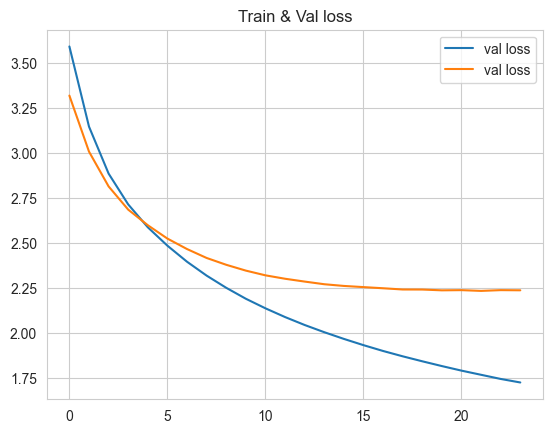

In [96]:
# 훈련 손실과 val loss 그래프 그리기
plt.plot(history.history['loss'], label='val loss')
plt.plot(history.history['val_loss'], label='val loss')

# 그래프에 타이틀 추가
plt.title('Train & Val loss')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기

- 테스트 단계에서는 정수 인덱스의 행렬형태로 존재하던 텍스트를 다시 텍스트로 복원해야 합니다.
- 이 작업에 필요한 사전 3개를 미리 준비합니다.

In [97]:
# 원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word

# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index

# 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word

- seq2seq는 훈련할때와 실제 동작(인퍼런스 단계)의 방식이 다릅니다.
- 따라서 각각의 방식에 맞게 모델 설계를 별개로 진행해야 합니다.

---

- 훈련 단계에서는 Decoder의 입력부에 정답이 되는 문장 전체를 일괄입력해서 Decoder의 출력과 한번에 비교할 수 있었습니다.
    - 그렇기 때문에 Encoder와 Decoder를 엮은 하나의 모델만 생성했었습니다.

- 하지만 정답 문장이 없이 요약을 생성해야 하는 인퍼런스 단계에서는 만들어야할 문장의 길이만큼 Decoder가 반복되는 구조로 작동됩니다.
- 따라서 인퍼런스 모델을 별도로 설계해 줘야 하는 것입니다.
    - 이 경우에는 기존과 달리 Encoder 모델과 Decoder모델을 분리해서 설계 합니다.

### Encoder 모델 설계

In [98]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

### 출력층 설계(feat. Attention Mechanism)

In [99]:
# 어텐션 함수
# 디코더의 현재 hidden state와 인코더의 모든 hidden state 간의 어텐션을 계산합니다.
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
# 어텐션을 적용한 디코더 출력을 활성화 함수인 'softmax'를 사용하여 확률 분포로 변환합니다.
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
# 디코더 모델을 정의합니다. 입력으로 디코더 입력, 현재 hidden state, 그리고 상태 정보를 받습니다.
# 출력으로 어텐션을 적용한 디코더 출력과 업데이트된 상태 정보를 반환합니다.
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 인퍼런스단계 구현 - 단어 시퀀스 완성 하는 함수

In [103]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS> 토큰을 디코더 입력 시퀀스의 첫 번째로 설정
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 모델을 사용하여 다음 토큰 예측
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        # 예측된 토큰이 'eostoken'이 아니면 디코딩 문장에 추가
        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # <eos>에 도달하거나 최대 길이를 넘으면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len-1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

## 모델 테스트

- 테스트시에는 정수 시퀀스를 텍스트 시퀀스로 변환해서 결과값을 얻을 수 있는 것이 좋습니다.
- 이를 위한 함수를 만들어 보겠습니다.

### seq2text 와 seq2summary 함수 생성

- 요약문에는 sostoken과 eostoke을 고려해서 요약문의 정수 시퀀스를 텍스트 시퀀스로 변경해야 합니다.

In [104]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0):  # 정수가 0이 아닌 경우에만 처리
            temp = temp + src_index_to_word[i] + ' '  # 정수를 단어로 변환하여 텍스트 시퀀스에 추가
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            # 정수가 0이 아니며, 시작 토큰('sostoken')과 종료 토큰('eostoken')이 아닌 경우에만 처리
            temp = temp + tar_index_to_word[i] + ' '  # 정수를 단어로 변환하여 텍스트 시퀀스에 추가
    return temp

- `if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):`
    - 이 부분은 정수 i가 0이 아니며 시작 토큰('sostoken') 및 종료 토큰('eostoken')이 아닌 경우에만 처리하도록 조건을 설정합니다.

- `temp = temp + tar_index_to_word[i] + ' '`
    - 조건을 만족하는 정수 i를 단어로 변환하여 텍스트 시퀀스에 추가합니다.
    
---

- 텍스트 데이터중 50개정도의 샘플을 실제요약과 예측된 요약을 비교해봅니다.

In [106]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : flipkart big sale starts bang today big discounts along discounts sale offers chance win free trip kuala lumpur free shopping gift every hour shoppers big benefits shoppers sale much bigger 
실제 헤드라인 : flipkart big sale begins today 
예측 요약 :  big offers to free for free


원문 : trailer arjun kapoor parineeti chopra starrer namaste england released lead stars worked together first time arjun debut film released year six years produced directed vipul shah film scheduled release october 
실제 헤드라인 : trailer of arjun parineeti england released 
예측 요약 :  trailer of parineeti parineeti starrer out


원문 : said extreme weather uk last week cost economy least billion day could gdp growth quarter sub zero temperatures like conditions caused deaths led closure schools hospitals winds dubbed beast east storm emma hit uk 
실제 헤드라인 : cost uk economy billion day 
예측 요약 :  cost of billion economy


원문 : us president donald trump pushed aside prime minister ensure centre photograph first joint meeting 

예측 요약 :  srk aamir kajol kajol on national day


원문 : us state secretary mike pompeo said country assure kim jong un ouster part agenda summit north korean leader president donald trump trade pending years pompeo added referring failed negotiations north korea years 
실제 헤드라인 : us will have to no change in korea 
예측 요약 :  us will not be to korea to trump


원문 : farmers tamil nadu completed days protest delhi jantar mantar tuesday demands include loan waivers revised drought packages cauvery management committee fair crop prices among others around protesting farmers threatened eat human draw attention authorities several others reportedly ate protests 
실제 헤드라인 : tamil nadu farmers days of protest in delhi 
예측 요약 :  tn farmers protest over budget


원문 : former bigg boss contestant tv actress hina khan denying reports make comeback serial yeh kya hai said never going happen earlier reports hina would star show dream sequence character would interact daughter played joshi 
실제 헤드라인 : never 

- 기존 요약과는 확실히 다른 요약을 출력하고 있고, 대체로 원문의 내용을 담고 있는 요약을 하는 결과를 보여줍니다.
- 일부 요약은 원문에 없던 단어를 사용해 요약을 하기도 합니다.
- 워드 임베딩에 RNN을 활용했기에 가능한 결과입니다.

---

# Step 5. Summa을 이용해서 추출적 요약 해보기

- 기존에는 seq2seq로 추상적 요약을 실습했습니다.
- 하지만 텍스트 요약에는 본문에 있는 단어구, 문장을 뽑아 요약하는 추출적 요약도 있습니다.

---

- `summa` 패키지를 사용해서 간단한 요약을 하는 방법으로 실습을 진행해 보겠습니다.

In [146]:
from summa.summarizer import summarize

# 데이터 불러오기
# 위에서 이미 다운받았으므로 로딩만 진행
df = pd.read_csv(filename, encoding='iso-8859-1')

# 무작위로 50개의 샘플 추출
samples = df.sample(n=50)

# 각 샘플에 대해 원문, 실제 헤드라인, 추출적 요약 수행
for i in samples.index:
    print("원문 :", samples.loc[i, 'text'])
    print("실제 헤드라인 :", samples.loc[i, 'headlines'])
    print("예측 요약 :", summarize(samples.loc[i, 'text'], ratio=0.5))
    print("\n")

원문 : Bengaluru-based biotech startup Pandorum Technologies has raised $3.2 million in Series A funding from Flipkart Co-founder Binny Bansal, Indian Angel Network and other individual investors. According to filings, the startup has already received $1.2 million and the remaining amount will come in tranches. Founded in 2011, the startup focusses on tissue engineering and regenerative medicine.
실제 헤드라인 : Flipkart Co-founder backs biotech startup Pandorum 
예측 요약 : According to filings, the startup has already received $1.2 million and the remaining amount will come in tranches.


원문 : After Sonam Kapoor, Masaba Gupta has taken a break from Twitter. On Wednesday, Masaba took to her Twitter and wrote, "Taking some time off from Twitter. My brain is going to explode." In one of her Instagram stories, Masaba wrote, "Gone off Twitter. I've always questioned whether I belong here and today I know for sure that I don't."
실제 헤드라인 : After Sonam Kapoor, Masaba Gupta takes break from Twitter
예측 요약

# Step 6. 추상적 요약 vs 추출적 요약

- 동일 원문에 대해 추상적 요약의 결과와 추출적 요약의 결과를 비교합니다.
    - 기준 1) 문법 완성도 측면
    - 기준 2) 핵심단어 포함 측면
    
- [Text Summarization Repo](https://github.com/uoneway/Text-Summarization-Repo)
- [20-01 어텐션을 이용한 텍스트 요약(Text Summarization with Attention mechanism)](https://wikidocs.net/72820)
- [ROUGE: A Package for Automatic Evaluation of Summaries](https://aclanthology.org/W04-1013/)
- [예시를 통한 ROUGE 성능 지표의 이해](https://huffon.github.io/2019/12/07/rouge/)

---

## 문법 완성도 측면 비교

### language_tool_python 테스트

- 문법 완성도 측면(1)
    - `language_tool_python` 라이브러리를 통해 입력한 문장에 대해 문법적 체크를 하고, 수정사항을 제안받을 수 있습니다.
    - 이 기능을 활용해 원문 헤드라인을 language_tool_python에 입력해 수정사항을 추천받으면 해당 문장과 요약한 문장의 일치율을 계산합니다.
    - 해당 결과들을 모든 테스트 데이터셋에 대해 구해서 일치율을 구해 문법완성도를 비교합니다.

In [147]:
# language_tool 객체 생성
tool = language_tool_python.LanguageTool('en-US')

# 텍스트 문법 오류 체크
text = "This is a example sentence with grammar mistake."
matches = tool.check(text)

# 발견된 문법 오류 출력
for match in matches:
    print(match)

Offset 8, length 1, Rule ID: EN_A_VS_AN
Message: Use “an” instead of ‘a’ if the following word starts with a vowel sound, e.g. ‘an article’, ‘an hour’.
Suggestion: an
This is a example sentence with grammar mistake.
        ^


### 테스트데이터셋을 이용해 추상적 요약 결과를 추출

In [149]:
from tqdm import tqdm

# 테스트 데이터셋 전체를 순회하며 각 컬럼의 데이터를 리스트에 저장
texts = []        # 원문을 저장할 리스트
headlines = []    # 실제 요약문을 저장할 리스트
summaries = []    # 예측 요약문을 저장할 리스트

# tqdm을 사용하여 진행 상황을 확인하면서 데이터를 저장
for i in tqdm(range(len(encoder_input_test)), desc="Processing"):
    texts.append(seq2text(encoder_input_test[i]))  # 원문 추가
    headlines.append(seq2summary(decoder_input_test[i]))  # 실제 헤드라인 추가
    summaries.append(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))  # 예측 요약 추가

# DataFrame 생성
abs_summaries = pd.DataFrame({'text': texts, 'headlines': headlines, 'summary': summaries})

# DataFrame 확인
abs_summaries.head()  # 생성된 DataFrame의 상위 5개 행을 출력하여 확인

Processing: 100%|██████████████████████████████████████████████████████████████| 19629/19629 [2:29:00<00:00,  2.20it/s]


,text,headlines,summary
0,nearly pakistani cricketers including saeed aj...,about pak cricketers stuck in over dispute,pak batsman to death over match
1,bjp became single largest party karnataka winn...,bjp as single largest party in taka with seats,bjp wins seats in seats in taka assembly seats
2,lok sabha session wednesday mos home affairs h...,no of any deaths linked to blue govt,minister suicide safety after suicide
3,bengaluru police wednesday arrested three susp...,fake aadhaar land pakistani in jail,held for pak women who held for
4,state run oil natural gas keen buy fuel retail...,to buy in deal worth crore,to buy petrol debt with


### 테스트데이터셋을 이용해 추출적 요약 결과를 추출

In [153]:
# 결과를 담을 DataFrame 생성
ext_summaries = pd.DataFrame(columns=['text', 'headlines', 'summary'])

# 데이터 불러오기 (이미 로딩된 데이터를 사용)
data = pd.read_csv(filename, encoding='iso-8859-1')

# tqdm을 사용하여 진행 상황을 확인하면서 요약 수행
for i in tqdm(data.index, desc="Processing"):
    text = data.loc[i, 'text']  # 'data'에서 'text' 컬럼의 데이터를 가져옵니다.
    headline = data.loc[i, 'headlines']  # 'data'에서 'headlines' 컬럼의 데이터를 가져옵니다.
    summary = summarize(text, ratio=0.5)  # 'text'를 사용하여 요약문을 생성합니다.
    
    # 결과를 ext_summaries DataFrame에 추가
    ext_summaries = ext_summaries.append({'text': text, 'headlines': headline, 'summary': summary}, ignore_index=True)

# 결과를 확인
print(ext_summaries.head()) # 생성된 DataFrame의 상위 5개 행을 출력하여 확인

Processing: 100%|███████████████████████████████████████████████████████████████| 98401/98401 [11:59<00:00, 136.82it/s]

                                                text  \
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...   
1  Kunal Shah's credit card bill payment platform...   
2  New Zealand defeated India by 8 wickets in the...   
3  With Aegon Life iTerm Insurance plan, customer...   
4  Speaking about the sexual harassment allegatio...   

                                           headlines  \
0  upGrad learner switches to career in ML & Al w...   
1  Delhi techie wins free food from Swiggy for on...   
2  New Zealand end Rohit Sharma-led India's 12-ma...   
3  Aegon life iTerm insurance plan helps customer...   
4  Have known Hirani for yrs, what if MeToo claim...   

                                             summary  
0  upGrad's Online Power Learning has powered 3 l...  
1  Users get one CRED coin per rupee of bill paid...  
2  The match witnessed India getting all out for ...  
3  Also, customers have options to insure against...  
4  Speaking about the sexual harassment allegatio..

In [156]:
# 생성된 df 저장
abs_summaries.to_csv('abs_summaries.csv', index = False)
ext_summaries.to_csv('ext_summaries.csv', index = False)

In [4]:
# 'abs_summaries.csv' 파일에서 데이터프레임 불러오기
abs_summaries = pd.read_csv('abs_summaries.csv')

# 'ext_summaries.csv' 파일에서 데이터프레임 불러오기
ext_summaries = pd.read_csv('ext_summaries.csv')

### 요약 방법별 성능 비교

In [157]:
# language_tool 객체 생성
tool = language_tool_python.LanguageTool('en-US')

def evaluate_grammar(text):
    """ 문장의 문법 오류 수를 반환합니다. """
    matches = tool.check(text)
    return len(matches)

# abs_summaries 데이터프레임에 대한 작업
# 헤드라인과 요약의 문법 오류 수를 평가하는 함수를 적용하여 오류 수 계산
abs_summaries['headline_grammar_errors'] = abs_summaries['headlines'].apply(evaluate_grammar)
abs_summaries['summary_grammar_errors'] = abs_summaries['summary'].apply(evaluate_grammar)
# 헤드라인과 요약의 문법 오류 수 차이를 계산하고 절댓값 적용
abs_summaries['error_difference'] = abs(abs_summaries['headline_grammar_errors'] - abs_summaries['summary_grammar_errors'])

# ext_summaries 데이터프레임에 대한 작업
# 헤드라인과 요약의 문법 오류 수를 평가하는 함수를 적용하여 오류 수 계산
ext_summaries['headline_grammar_errors'] = ext_summaries['headlines'].apply(evaluate_grammar)
ext_summaries['summary_grammar_errors'] = ext_summaries['summary'].apply(evaluate_grammar)
# 헤드라인과 요약의 문법 오류 수 차이를 계산하고 절댓값 적용
ext_summaries['error_difference'] = abs(ext_summaries['headline_grammar_errors'] - ext_summaries['summary_grammar_errors'])

# 결과 확인
# 결과를 출력하여 헤드라인, 요약 및 오류 수 차이를 확인합니다.
display(abs_summaries[['headlines', 'summary', 'error_difference']].head())
display(ext_summaries[['headlines', 'summary', 'error_difference']].head())

# abs_summaries 데이터프레임의 error_difference 평균 계산
abs_avg_error_diff = abs_summaries['error_difference'].mean()
print("abs_summaries의 평균 문법 오류 차이:", abs_avg_error_diff)

# ext_summaries 데이터프레임의 error_difference 평균 계산
ext_avg_error_diff = ext_summaries['error_difference'].mean()
print("ext_summaries의 평균 문법 오류 차이:", ext_avg_error_diff)

,headlines,summary,error_difference
0,about pak cricketers stuck in over dispute,pak batsman to death over match,1
1,bjp as single largest party in taka with seats,bjp wins seats in seats in taka assembly seats,1
2,no of any deaths linked to blue govt,minister suicide safety after suicide,0
3,fake aadhaar land pakistani in jail,held for pak women who held for,1
4,to buy in deal worth crore,to buy petrol debt with,0


,headlines,summary,error_difference
0,upGrad learner switches to career in ML & Al w...,upGrad's Online Power Learning has powered 3 l...,0
1,Delhi techie wins free food from Swiggy for on...,Users get one CRED coin per rupee of bill paid...,3
2,New Zealand end Rohit Sharma-led India's 12-ma...,The match witnessed India getting all out for ...,1
3,Aegon life iTerm insurance plan helps customer...,"Also, customers have options to insure against...",2
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,4


abs_summaries의 평균 문법 오류 차이: 0.6020174232003668
ext_summaries의 평균 문법 오류 차이: 1.016798609770226


- 결과를 보면 두 요약 방식의 문법 오류 차이 평균값은 추상적 요약(abs_summaries)의 error_diff의 평균이 더 낮아, 문법적으로는 더 좋은 성능을 나타내고 있음을 알 수 있습니다.

## 핵심 단어 측면 비교

### Simple ver. 키워드 기반 비교 방법
- headlines와 summary에서 각각 키워드를 추출하고, 이들 간의 겹침을 계산해 성능을 평가합니다.
- 이때 키워드 추출시 단순 빈도뿐 아니라 맥락을 고려한 TF-IDF를 사용해 추출하여 겹침을 계산합니다.

---

- extract_keywords로 주어진 텍스트에서 빈도가 가장 높은 상위 단어를 추출합니다.
- calculate_keyword_overlap 함수를 사용해 각 데이터 프레임에서 headlines와 summary에 대해 추출된 주요 키워드의 겹침정도를 계산합니다.
    - 겹침 비율은 두 집합의 교집합 크기를 합집합 크기로 나눠서 계산합니다.
- 이후 모든 행에 대해 계산된 겹침 비율의 평균을 계산해서 결과값을 구합니다.

In [159]:
# 필요한 라이브러리 가져오기
from collections import Counter
import numpy as np

# 텍스트에서 키워드 추출하는 함수 정의
def extract_keywords(text, top_n=5):
    # 텍스트를 단어로 분할
    words = text.split()
    # 단어 빈도수 계산
    frequency = Counter(words)
    # 가장 빈도가 높은 상위 N개의 단어 추출
    return set(word for word, freq in frequency.most_common(top_n))

# 키워드 겹침 비율 계산하는 함수 정의
def calculate_keyword_overlap(df):
    overlaps = []
    for _, row in df.iterrows():
        # 헤드라인과 요약의 키워드 추출
        headline_keywords = extract_keywords(row['headlines'])
        summary_keywords = extract_keywords(row['summary'])
        # 겹친 키워드 수와 전체 키워드 수의 비율 계산
        overlap = len(headline_keywords.intersection(summary_keywords)) / len(headline_keywords.union(summary_keywords))
        overlaps.append(overlap)
    return np.mean(overlaps)

# 'abs_summaries'와 'ext_summaries'에 대한 키워드 겹침 비율 계산
keyword_overlap_abs = calculate_keyword_overlap(abs_summaries)
keyword_overlap_ext = calculate_keyword_overlap(ext_summaries)

# 결과 출력
print("abs_summaries의 키워드 겹침 비율:", keyword_overlap_abs)
print("ext_summaries의 키워드 겹침 비율:", keyword_overlap_ext)

abs_summaries의 키워드 겹침 비율: 0.17723478866303258
ext_summaries의 키워드 겹침 비율: 0.08208052312024833


- 결과값으로 보자면 기존 headline과 겹치는 핵심단어를 더 많이 사용해 요약한 것은 추론적 요약입니다.
- 즉 추론적 요약방식이 추출적 요약보다 원본 헤드라인의 핵심단어를 더 잘 포착하고 있음을 의미합니다.
- 다만, 이 방식은 단순히 키워드의 겹침에만 초점을 맞추고 있어 전반적인 요약의 품질을 단정짓기에는 다소 부족한 평가 방법이라 생각합니다.
- 이를 보완하기위해 임베딩 모델을 사용해서 텍스트의 의미적 유사성을 평가하는 방식을 시도해보겠습니다.

### Hard ver. 키워드 기반 비교 방법

- word2vec이나 BERT같은 임베딩 모델을써서 텍스트의 의미적 유사성을 평가하는 방식을 사용할 수 있습니다.
- 임베딩으로 각 문장을 벡터로 변환한 뒤, 벡터간의 코사인 유사도 등의 메트릭을 통해 유사성을 계산합니다.
- 맥락적/의미적 유사성을 더 고려하기에 적합한 평가 방법이라 생각됩니다.
- 이번에는 BERT를 사용해서 평가를 진행해보도록 하겠습니다.

In [ ]:
# 필요한 라이브러리 가져오기
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from scipy.spatial.distance import cosine
import numpy as np

# BERT 모델과 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# 텍스트의 임베딩을 얻는 함수 정의
def get_embedding(text):
    # 입력 텍스트를 토큰화하고 BERT 모델에 전달
    inputs = tokenizer(text, return_tensors="tf", truncation=True, max_length=512)
    outputs = model(inputs)
    # 임베딩의 평균값 계산
    return tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()

# 데이터프레임의 각 행에 대한 코사인 유사도 계산
def calculate_cosine_similarity(df):
    similarities = []
    for _, row in df.iterrows():
        # 헤드라인과 요약의 임베딩 얻기
        headline_embedding = get_embedding(row['headlines'])
        summary_embedding = get_embedding(row['summary'])
        # 코사인 유사도 계산
        similarity = 1 - cosine(headline_embedding, summary_embedding)
        similarities.append(similarity)
    return np.mean(similarities)

# 'abs_summaries'와 'ext_summaries'에 대한 코사인 유사도 계산
cosine_similarity_abs = calculate_cosine_similarity(abs_summaries)
cosine_similarity_ext = calculate_cosamine_similarity(ext_summaries)

# 결과 출력
print("abs_summaries의 코사인 유사도:", cosine_similarity_abs)
print("ext_summaries의 코사인 유사도:", cosine_similarity_ext)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

- BERT로 임베딩 하는것은 아무래도 많은 시간이 걸려서 퀘스트 시간내에 결론을 내서 답변을 확인하기는 어려울 것 같습니다.
- 제출 가능한 부분까지만 정리하여 노트를 제출하고 추후 업데이트 하도록 하겠습니다.

---

## 문장 완성도 & 핵심단어 종합 평가

### ROGUE 평가

- 문법 완성도 & 핵심문장 종합 평가
    - ROUGE(Remembering Overlap Grows Understanding of Gists) 메트릭을 사용해 평가합니다.
    - ROUGE는 자동 요약의 성능을 평가하는데 널리 사용되는 지표중 하나입니다.
    - ROGUE는 요약문과 참조문(여기서는 headlines)간 겹치는 단어나 구를 기반으로 성능을 평가합니다.
    - ROGUE를 평가하는 수치 3가지는 아래와 같은 의미를 갖고 있습니다.
---

- ROUGE-N: 이 컴포넌트는 N-gram (단어 또는 구의 연속적인 일련의 토큰) 중복을 측정합니다. 
    - ROUGE-1은 단어 단위의 중복을 측정하고, ROUGE-2는 이중 단어 중복을 측정합니다. 
    - ROUGE-N에서 N의 값은 중복의 크기를 결정합니다.

- ROUGE-L: 이 컴포넌트는 최장 공통 부분 순열(Longest Common Subsequence, LCS)을 기반으로 합니다. 요약문과 참조문 사이의 최장 중복 부분을 찾아 성능을 측정합니다.

- ROUGE-W: 이 컴포넌트는 가중치를 사용하여 중요한 단어의 중복을 강조합니다. 특정 단어가 요약문과 참조문 양쪽에 더 자주 나타나면 이를 반영하여 성능을 측정합니다.

In [9]:
from rouge_score import rouge_scorer


def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # 문자열이 아닌 경우 빈 문자열로 대체
    return text

def calculate_rouge_scores(df):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = []

    for _, row in df.iterrows():
        headline = preprocess_text(row['headlines'])
        summary = preprocess_text(row['summary'])
        score = scorer.score(headline, summary)
        scores.append(score)
        
    # 평균 ROUGE 스코어 계산
    avg_rouge_scores = {
        'rouge-1': np.mean([score['rouge1'].fmeasure for score in scores]),
        'rouge-2': np.mean([score['rouge2'].fmeasure for score in scores]),
        'rouge-l': np.mean([score['rougeL'].fmeasure for score in scores])
    }
    return avg_rouge_scores

# abs_summaries와 ext_summaries의 ROUGE 스코어 계산
abs_rouge_scores = calculate_rouge_scores(abs_summaries)
ext_rouge_scores = calculate_rouge_scores(ext_summaries)

print("abs_summaries의 평균 ROUGE 스코어:", abs_rouge_scores)
print("ext_summaries의 평균 ROUGE 스코어:", ext_rouge_scores)

abs_summaries의 평균 ROUGE 스코어: {'rouge-1': 0.29516933723903627, 'rouge-2': 0.07324670210602474, 'rouge-l': 0.272846570519592}
ext_summaries의 평균 ROUGE 스코어: {'rouge-1': 0.3249364917733944, 'rouge-2': 0.12928076427878635, 'rouge-l': 0.2739795631934649}


- abs_summaries의 평균 ROUGE 스코어:
    - ROUGE-1 스코어: 0.295
    - ROUGE-2 스코어: 0.073
    - ROUGE-L 스코어: 0.273
- ext_summaries의 평균 ROUGE 스코어:
    - ROUGE-1 스코어: 0.325
    - ROUGE-2 스코어: 0.129
    - ROUGE-L 스코어: 0.274
    
---

- ROUGE-1 스코어는 단어 단위의 중복을 측정하며, abs_summaries의 경우 약 0.295, ext_summaries의 경우 약 0.325로 나타났습니다. 
    - 더 높은 ROUGE-1 스코어는 요약문과 참조문 사이의 단어 중복을 나타냅니다.
- ROUGE-2 스코어는 이중 단어 중복을 측정하며, abs_summaries의 경우 약 0.073, ext_summaries의 경우 약 0.129로 나타났습니다. 
    - ROUGE-2 스코어가 더 높다는 것은 요약문과 참조문 간에 이중 단어 중복이 더 많이 발생했음을 의미합니다.
- ROUGE-L 스코어는 최장 중복 부분을 측정하며, 두 데이터셋 모두 약 0.273에서 0.274의 스코어를 나타냈습니다.

- 요약하면, ext_summaries의 경우 ROUGE 스코어가 abs_summaries보다 더 높으므로 자동 요약이 참조문장(헤드라인)과 더 유사한 요약을 했음을 의미합니다.

---

### 📝 평가 비교 결과 종합

- 문법자체의 완성도나 핵심단어 측면에서는 추상적 요약의 성능이 더 뛰어난 것으로 보입니다.
- 반면에 ROGUE를 기준으로 종합적인 평가를 한 경우에는 추출적 요약의 문장이 더 뛰어난 요약을 한 것으로 평가됩니다.
- 실제로 요약된 결과를 보면 대부분의 추출적 요약은 헤드라인의 문장을 거의 그대로 유지한 수준으로 요약이 되고 있어서 이런 결과가 나온 것이 아닐까 합니다.

---

# 회고

## KEEP
- 학습노드에서 배운 내용을 바탕으로 다른 데이터에도 적용할 수 있을 정도로 내용 파악이 되어 있었습니다.
- 텍스트 데이터에 대한 EDA를 진행해 처리 방향을 더 심도 있게 고려했습니다.
- 다양한 성능 비교 방식을 사용하려 시도했습니다.

---
## PROMBLEM
- 나름대로 설계를 하긴 했지만, 패딩하기 위한 기준에 적합한지에 대한 확신이 잘 안선다.
- 성능 비교 방식이 너무 과도한듯하다(연산에 너무 많은 시간이 걸리는 방식)
- Beam Search 방식으로 Decoder를 바꾸는 시도를 했었는데, 완전히 하드코딩으로 해서 그런지 결과가 엉망이어서 지워버렸다.
	- Transformer 방식에 적용하는 Beam search는 많았는데 seq2seq에 적용하는 코드는 나오지 않아서 불가피 하게 하드코딩
---
## TRY
- Beam Search하는 방법 찾아서 적용해보기
- 더 빠르고 효율적인 모델 성능 평가 방법 찾아서 적용해보기
---